In [ ]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/1x1/'
hr_data_path='input_data/deg/0_5x0_5/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (160, 290)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input

def create_srcnn():
    input_img = Input(shape=(160, 290, 1))

    # Feature extraction layer
    x = Conv2D(filters=64, kernel_size=(9,9), activation='relu', padding='same')(input_img)

    # Non-linear mapping layer
    x = Conv2D(filters=32, kernel_size=(5,5), activation='relu', padding='same')(x)

    # Reconstruction layer
    output_img = Conv2D(filters=1, kernel_size=(5,5), activation='linear', padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [ ]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std, True, target_size)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 160, 290, 1)
(21478, 160, 290, 1)
(4602, 160, 290, 1)
(4602, 160, 290, 1)


In [ ]:
# Initialize the model
srcnn_model = create_srcnn()
srcnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 160, 290, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 160, 290, 64)        │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 160, 290, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 160, 290, 1)         │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,281 (223.75 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 287ms/step - loss: 0.0361 - mae: 0.0361 - mse: 0.0049 - psnr: 27.6015 - ssim: 0.8255 - val_loss: 0.0083 - val_mae: 0.0083 - val_mse: 2.6726e-04 - val_psnr: 35.7311 - val_ssim: 0.9503 - learning_rate: 0.0010
Epoch 2/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 0.0096 - mae: 0.0096 - mse: 2.7098e-04 - psnr: 35.7427 - ssim: 0.9522 - val_loss: 0.0078 - val_mae: 0.0078 - val_mse: 1.9106e-04 - val_psnr: 37.1887 - val_ssim: 0.9564 - learning_rate: 0.0010
Epoch 3/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 0.0080 - mae: 0.0080 - mse: 1.9211e-04 - psnr: 37.1685 - ssim: 0.9569 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 1.8127e-04 - val_psnr: 37.4170 - val_ssim: 0.9586 - learning_rate: 0.0010
Epoch 4/200
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 0.0076 - mae: 0.0076 - mse: 1.7902e-04 - psnr: 37.4742 - ssim: 0.9587 - val_loss: 0.0076 - val_mae: 0.0076 - val_mse: 1.7518e-04 - val_psnr: 37.5654 - val_ssim: 0.9592 - le

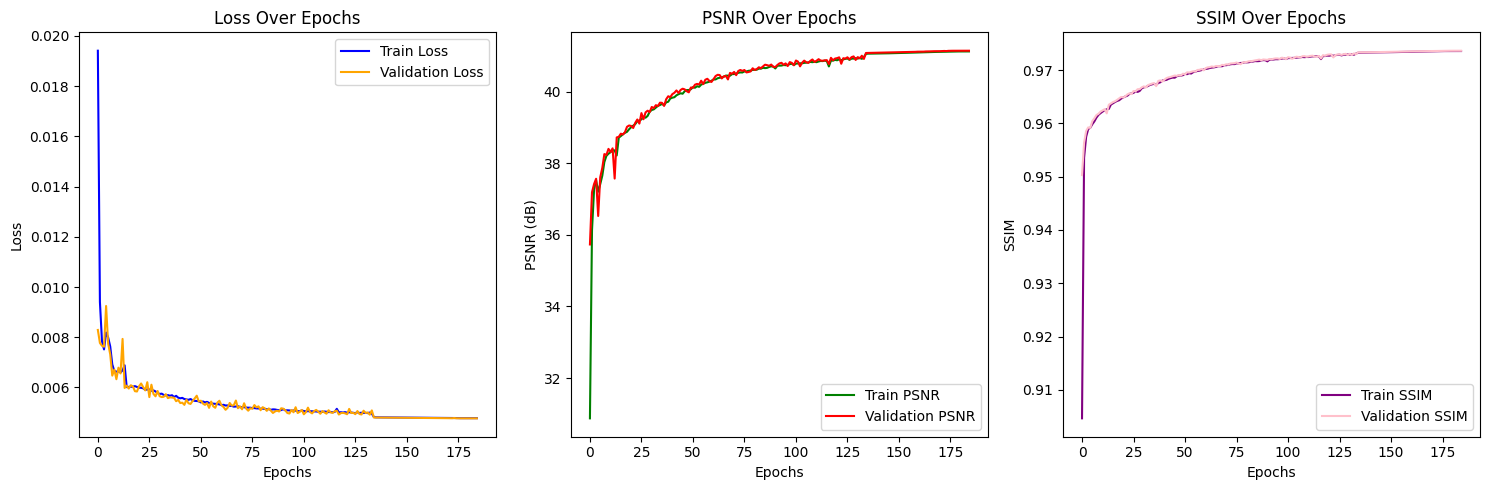

In [ ]:
history = train_model(srcnn_model, trainX, trainY, valX, valY, 200, 128, True, True, 50, 40)
plot_history(history)
save_model(srcnn_model, 'models/srcnn_model_1to0_5_deg_200epochs.keras')

In [ ]:
# srcnn_model = tf.keras.models.load_model('models/srcnn_model_1to0_5_deg_200epochs.keras', custom_objects={'psnr': psnr, 'ssim': ssim})

In [ ]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = srcnn_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0048 - mae: 0.0048 - mse: 7.8377e-05 - psnr: 41.0614 - ssim: 0.9732
Test Loss: 0.004815736785531044
Test PSNR: 41.05526351928711
Test SSIM: 0.973260223865509
Test MSE: 7.848982204450294e-05
Test MAE: 0.004815736319869757


In [ ]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = srcnn_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


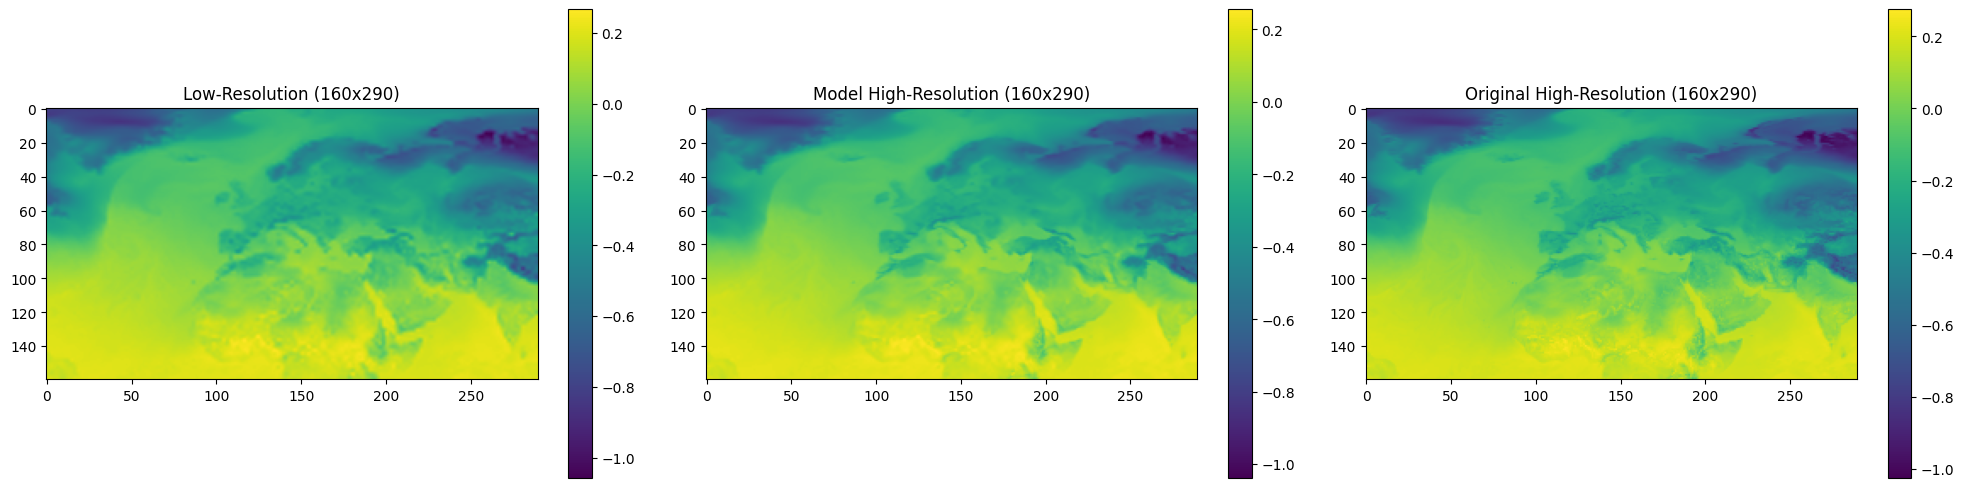

In [ ]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

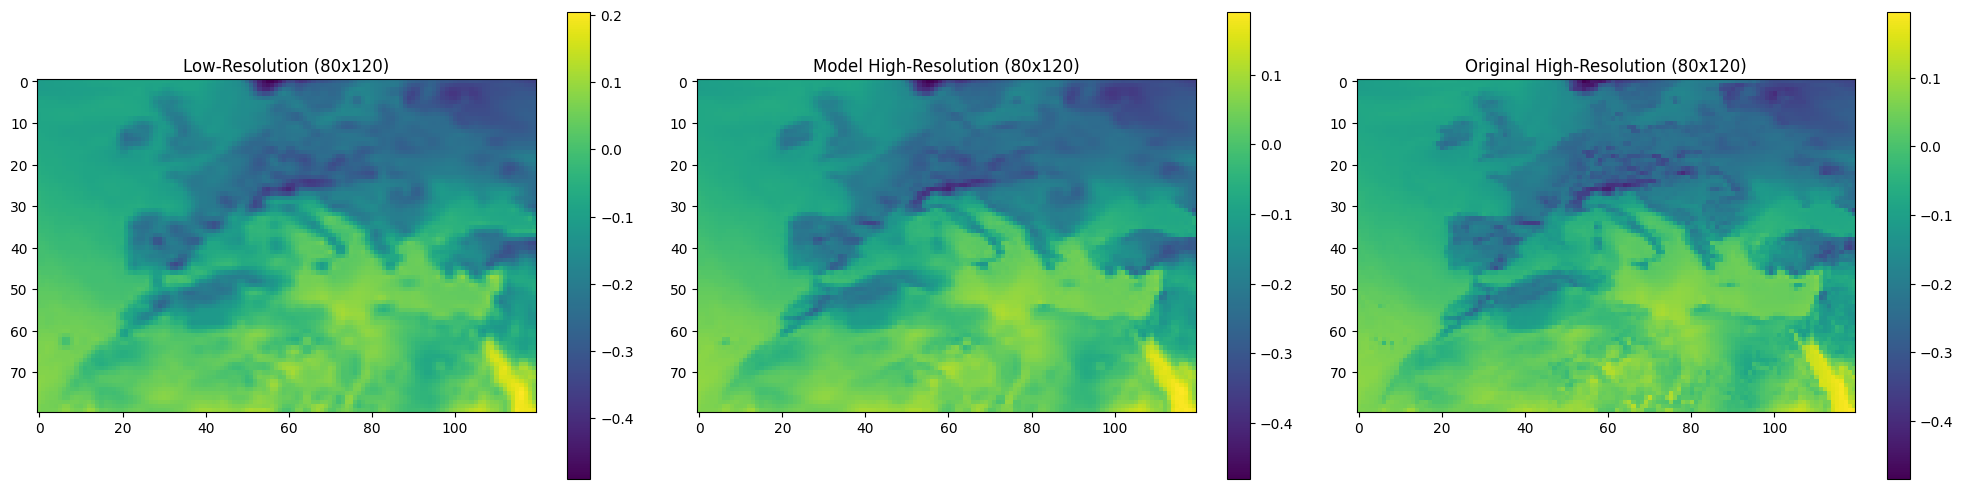

In [ ]:
plot_to_compare(low_res_input[40:120, 80:200], np.squeeze(high_res_data)[40:120, 80:200],  np.squeeze(high_res_output)[40:120, 80:200], 'viridis')

In [ ]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(srcnn_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Per-pixel MSE shape: (160, 290, 1)
Per-pixel MAE shape: (160, 290, 1)
Per-pixel PSNR shape: (160, 290, 1)
Per-pixel SSIM shape: (160, 290, 1)
Mean Per-Pixel MSE: 7.848983e-05
Mean Per-Pixel MAE: 0.0048157373
Mean Per-Pixel PSNR: 46.74753
Mean Per-Pixel SSIM: 0.9907277


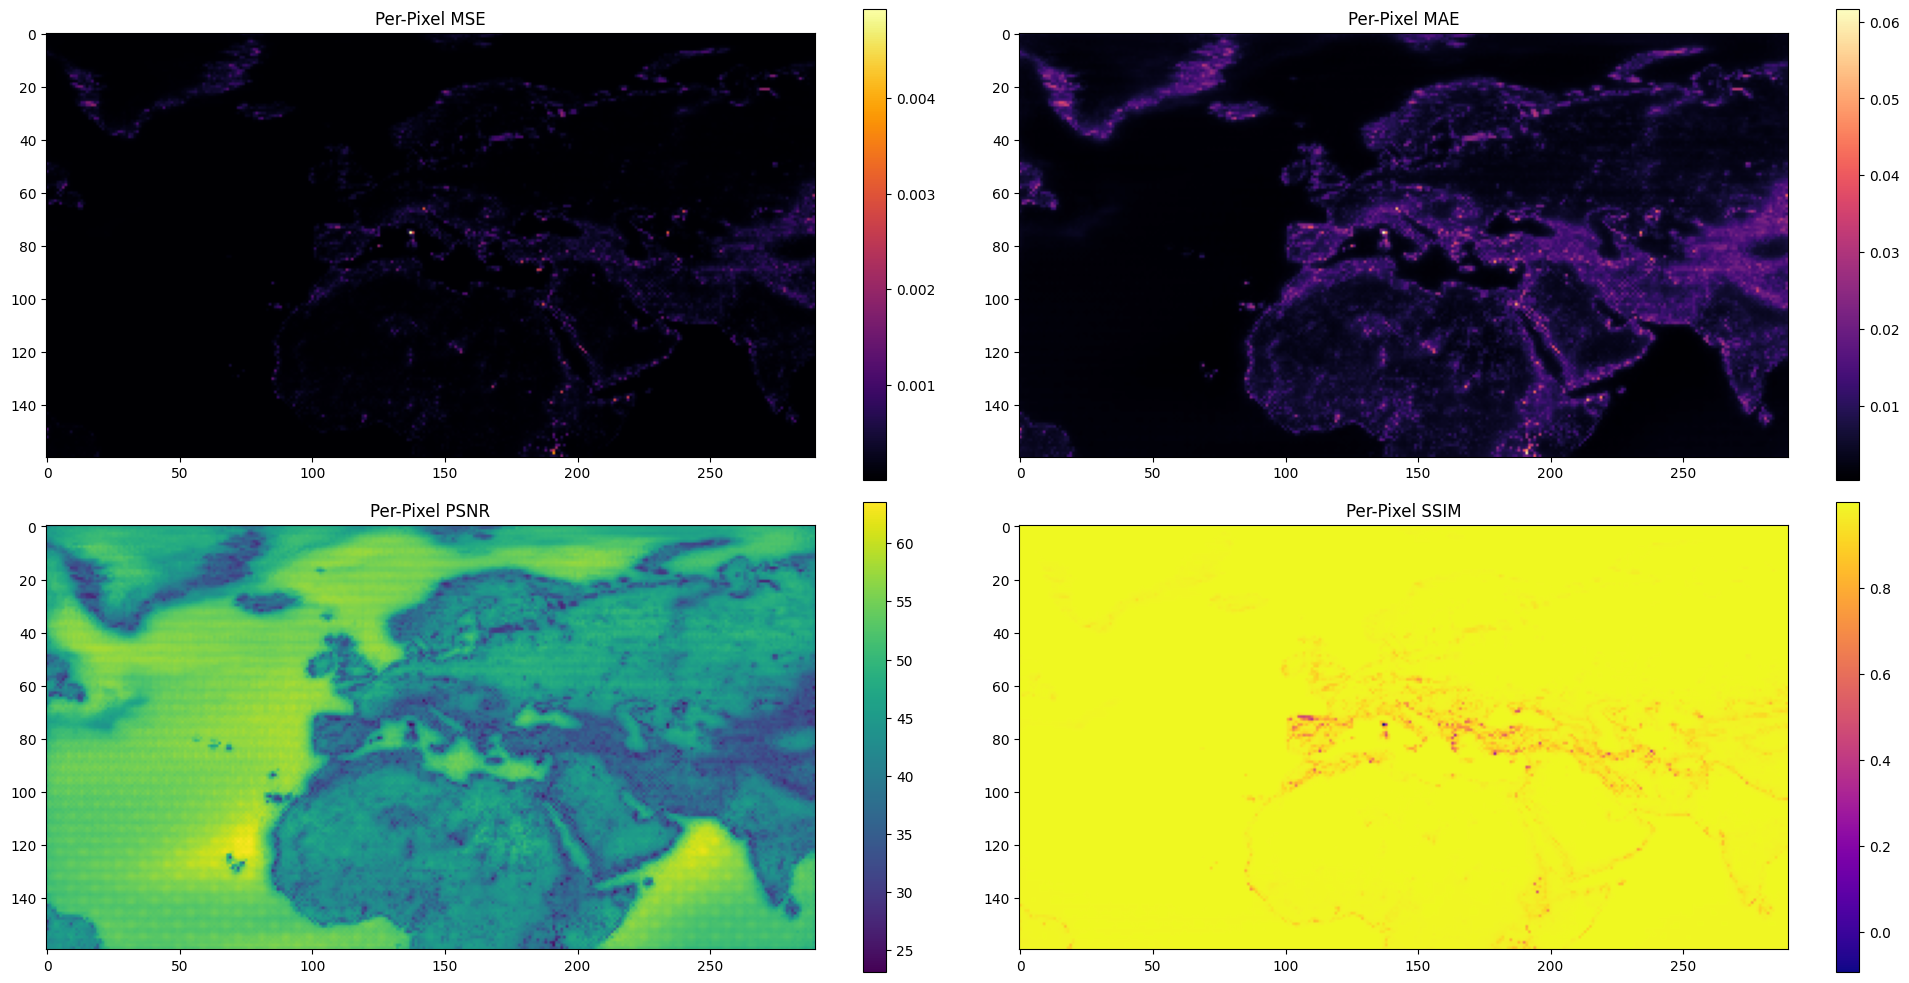

In [ ]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.30944392
Max Degrees MAE: 3.9557567
Min Degrees MAE: 0.02872576


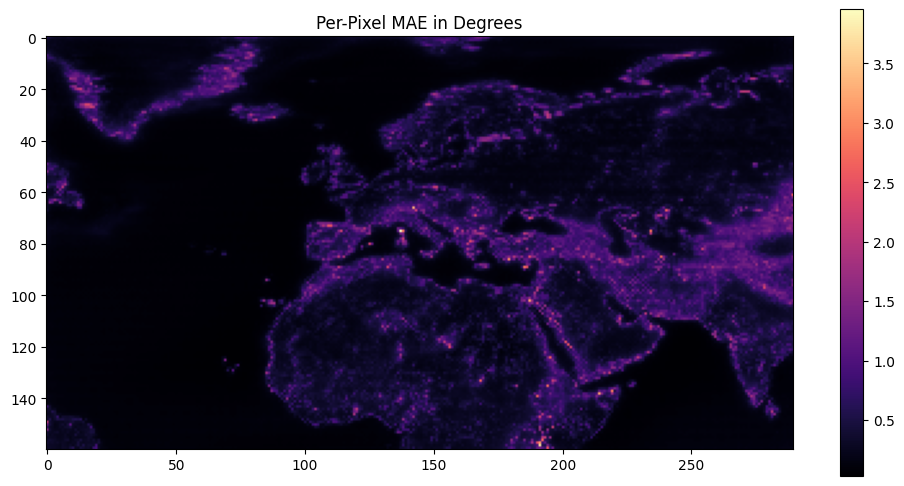

In [ ]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [ ]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_5'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_5'))

Mean Land-Pixels Degrees MAE: 0.46989313
Mean Land-Pixels MAE: 0.0073127374


In [ ]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_5'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_5'))

Mean Coastline-Pixels Degrees MAE: 0.71575993
Mean Costline-Pixels MAE: 0.011139051
